In [34]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Part 1: Processing the data 
# Set random seeds to ensure repeatable results
seed = 8
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load data
data = pd.read_csv('heart2.csv')

# Check the data type
print("The data type:\n",data.dtypes)

# Remove missing value
data = data.dropna()

# Convert data into readable form using unique thermal coding
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data = pd.get_dummies(data, columns=categorical_cols)

# Check the processed data and processed data type
print("\nThe head of data：")
print(data.head())
print("\nTotal data (number of rows): ", data.shape[0])
print("Number of features (number of columns): ", data.shape[1])

# Extract features and labels
X = data.drop(columns=['HeartDisease']).values
y = data['HeartDisease'].values

# Data standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Data set segmentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Convert to PyTorch's tensor format and create a DataLoader
batch_size = 256
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          generator=torch.Generator().manual_seed(seed))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


The data type:
 Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

The head of data：
   Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_F  Sex_M  ChestPainType_ASY  ...  ChestPainType_NAP  ChestPainType_TA  \
0  False   True              False  ...              False             False   
1   True  False             

In [35]:
# Part 2: Design neural network structure
# Define a neural network
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()

        # Build network layer
        self.layers.append(nn.Linear(input_size, hidden_layers[0])) # Fully connected layer
        self.layers.append(nn.ReLU())# Activation function
        self.layers.append(nn.Dropout(p=dropout_rate))  # Dropout is a regularisation technique

        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))  

        self.layers.append(nn.Linear(hidden_layers[-1], 2))  # Output layer
        self.softmax = nn.Softmax(dim=1) # Output activation function
        

    # Forward Pass
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x


# Define hyperparameters
input_size = X_train_tensor.shape[1] # Input size
hidden_layers = [64,32]  # Number of hidden layers and neurons
dropout_rate = 0.2  # The rate of Dropout
learning_rate = 0.001  # Learning rate
alpha = 0.001  # L2 regularization
num_epochs = 150  # Maximum iterations
early_stop_patience = 10  # Tolerance number of early stops

# Model Instantiation
model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
print(model) # Check the structure of model
Loss_fun = nn.CrossEntropyLoss() # Define Loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha) # Define Optimizer


HeartDiseaseANN(
  (layers): ModuleList(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
  (softmax): Softmax(dim=1)
)


In [36]:
# Part 3: Setup training procedure
# Record training and validation losses and accuracy as well as early stop implementations
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
patience_counter = 0
delta = 1e-4  # Tolerate minimal change

# The training process for each round
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    # Batch-by-batch training
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        # Compute the loss
        loss = Loss_fun(outputs, y_batch) 
        # Backward Pass
        loss.backward()
        optimizer.step()

        # Calculate the total of training loss of the entire training set 
        # and count the correct predictions
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()

    # Calculate average training losses and accuracy
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_correct / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Verification phase
    model.eval()
    val_loss = 0.0
    val_correct = 0

    # Disable gradient calculation 
    #(Because the verification result segment does not need to backpropagate to update the gradient)
    with torch.no_grad(): 
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            
    # Calculate average validation losses and accuracy
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_correct / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}")

    # Set early stop
    # Count if the loss on the verification set is constant, 
    # and stop training if it is greater than or equal to the set early stop value.
    if avg_val_loss < best_val_loss-delta:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"Early stop triggered! Stopping training at epoch {epoch+1}.")
            break




Epoch 1/150, Training Loss: 0.6844, Training Accuracy: 0.5763, Validation Loss: 0.6846, Validation Accuracy: 0.5435
Epoch 2/150, Training Loss: 0.6742, Training Accuracy: 0.6417, Validation Loss: 0.6752, Validation Accuracy: 0.5761
Epoch 3/150, Training Loss: 0.6634, Training Accuracy: 0.6717, Validation Loss: 0.6653, Validation Accuracy: 0.6196
Epoch 4/150, Training Loss: 0.6495, Training Accuracy: 0.7302, Validation Loss: 0.6545, Validation Accuracy: 0.6685
Epoch 5/150, Training Loss: 0.6393, Training Accuracy: 0.7589, Validation Loss: 0.6426, Validation Accuracy: 0.7283
Epoch 6/150, Training Loss: 0.6232, Training Accuracy: 0.7943, Validation Loss: 0.6295, Validation Accuracy: 0.7500
Epoch 7/150, Training Loss: 0.6090, Training Accuracy: 0.8025, Validation Loss: 0.6151, Validation Accuracy: 0.7772
Epoch 8/150, Training Loss: 0.5928, Training Accuracy: 0.8202, Validation Loss: 0.5995, Validation Accuracy: 0.7772
Epoch 9/150, Training Loss: 0.5761, Training Accuracy: 0.8379, Validatio

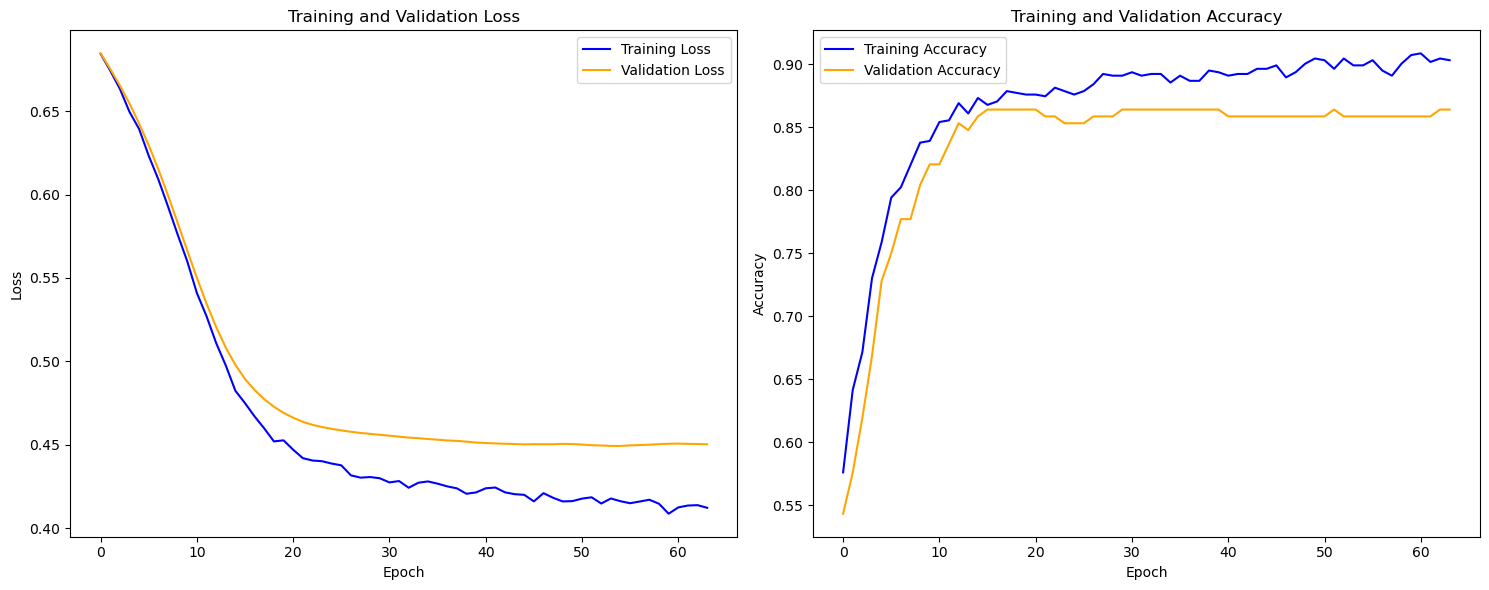

In [37]:
# Part 4: Visualise the training and validation process
plt.figure(figsize=(15, 6))

# Plot training and verify losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Draw training and verify accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

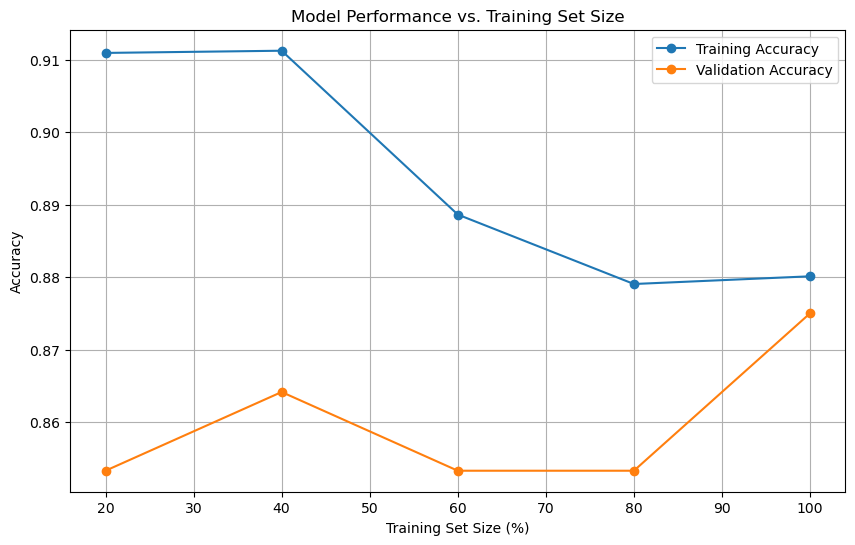

In [38]:
# Experiment with different training set sizes
train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]  # Different proportions of training data
train_accuracies_per_size = []  
val_accuracies_per_size = []  

for train_size in train_sizes:
    # Sample a subset of training data based on the current ratio
    subset_size = int(train_size * len(X_train))
    subset_indices = np.random.choice(len(X_train), subset_size, replace=False)
    
    X_train_subset = X_train[subset_indices]
    y_train_subset = y_train[subset_indices]

    # Convert to PyTorch's tensor format and create DataLoader
    X_train_tensor = torch.tensor(X_train_subset, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_subset, dtype=torch.long)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

    # Model Instantiation
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    Loss_fun = nn.CrossEntropyLoss()  # Define Loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)  # Define Optimizer

    # Record training and validation losses and accuracy as well as early stop implementations
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    patience_counter = 0
    delta = 1e-4  # Tolerate minimal change

    # The training process for each round
    for epoch in range(num_epochs):
        model.train()
        train_correct = 0

        # Batch-by-batch training
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            # Compute the loss
            loss = Loss_fun(outputs, y_batch)
            # Backward Pass
            loss.backward()
            optimizer.step()

            # Count correct predictions
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        # Calculate average training accuracy
        avg_train_acc = train_correct / len(train_loader.dataset)
        train_accuracies.append(avg_train_acc)

        # Verification phase
        model.eval()
        val_correct = 0

        # Disable gradient calculation
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()

        # Calculate average validation accuracy
        avg_val_acc = val_correct / len(test_loader.dataset)
        val_accuracies.append(avg_val_acc)

        # Early stop logic
        val_loss = loss.item()
        if val_loss < best_val_loss - delta:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                break

    # Record final accuracies for each training set size
    train_accuracies_per_size.append(train_accuracies[-1])
    val_accuracies_per_size.append(val_accuracies[-1])


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([int(size * 100) for size in train_sizes], train_accuracies_per_size, label='Training Accuracy', marker='o')
plt.plot([int(size * 100) for size in train_sizes], val_accuracies_per_size, label='Validation Accuracy', marker='o')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Accuracy')
plt.title('Model Performance vs. Training Set Size')
plt.legend()
plt.grid(True)
plt.show()

Best learning rate: 0.01 with validation accuracy: 0.8750


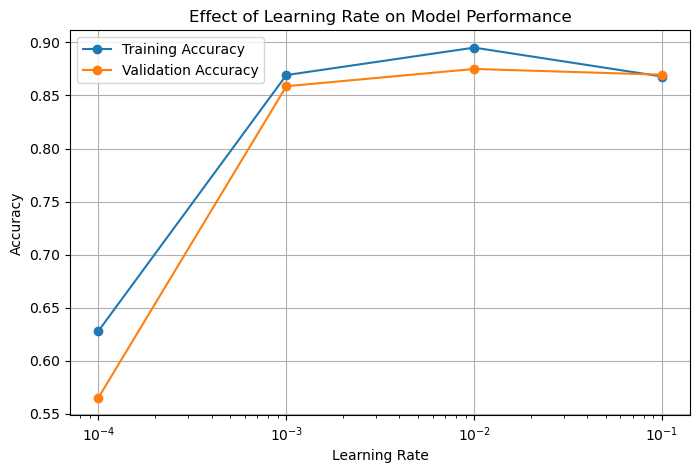

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

# Set a random seed for reproducibility
seed = 8
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(seed)

# Define Neural Network Class
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()

        # Input Layer
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))

        # Hidden Layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))

        # Output Layer
        self.layers.append(nn.Linear(hidden_layers[-1], 2))  # Binary classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x

# Function to Train and Evaluate the Model
def train_and_evaluate_model(learning_rate):
    set_seed(seed)  # Ensure consistent results for every hyperparameter setting
    
    # Instantiate model, optimizer, and loss function
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()

    # Track accuracies
    train_accuracies = []
    val_accuracies = []
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    delta = 1e-4  # Early stopping threshold
    
    for epoch in range(num_epochs):
        model.train()
        train_correct = 0

        # Training phase
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        avg_train_acc = train_correct / len(train_loader.dataset)
        train_accuracies.append(avg_train_acc)

        # Validation phase
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()

        avg_val_acc = val_correct / len(test_loader.dataset)
        val_accuracies.append(avg_val_acc)

        # Early stopping check
        if avg_val_acc > best_val_loss + delta:
            best_val_loss = avg_val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                break

    return train_accuracies, val_accuracies


# Define hyperparameters
input_size = X_train_tensor.shape[1] # Input size
hidden_layers = [64,32]  # Number of hidden layers and neurons
dropout_rate = 0.2  # The rate of Dropout
alpha = 0.001  # L2 regularization
num_epochs = 150  # Maximum iterations
early_stop_patience = 15  # Tolerance number of early stops

# Hyperparameter (Learning Rate) to Explore
learning_rates = [0.1, 0.01, 0.001, 0.0001]
train_accuracies_rates = []
val_accuracies_rates = []

best_learning_rate = None
best_val_accuracy = 0

# Train and Evaluate for Each Learning Rate
for lr in learning_rates:
    train_accuracies, val_accuracies = train_and_evaluate_model(learning_rate=lr)
    max_val_acc = max(val_accuracies)
    train_accuracies_rates.append(train_accuracies[val_accuracies.index(max_val_acc)])
    val_accuracies_rates.append(max_val_acc)
    
    if max_val_acc > best_val_accuracy:
        best_val_accuracy = max_val_acc
        best_learning_rate = lr

print(f"Best learning rate: {best_learning_rate} with validation accuracy: {best_val_accuracy:.4f}")

# Plot Results for Learning Rate
plt.figure(figsize=(8, 5))
plt.plot(learning_rates, train_accuracies_rates, label='Training Accuracy', marker='o')
plt.plot(learning_rates, val_accuracies_rates, label='Validation Accuracy', marker='o')
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Effect of Learning Rate on Model Performance")
plt.xscale('log')  # Log scale for better visualization
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Function to Train and Evaluate the Model
def train_and_evaluate_model(learning_rate):
    set_seed(seed)  # Ensure consistent results for every hyperparameter setting
    
    # Instantiate model, optimizer, and loss function
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()

    # Track accuracies
    train_accuracies = []
    val_accuracies = []
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    delta = 1e-4  # Early stopping threshold
    
    for epoch in range(num_epochs):
        ...# Same with the training process in Section1

    return train_accuracies, val_accuracies

In [8]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Set random seed
seed = 8
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load data
data = pd.read_csv('heart2.csv')
data = data.dropna()


categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data = pd.get_dummies(data, columns=categorical_cols)


X = data.drop(columns=['HeartDisease']).values
y = data['HeartDisease'].values

# Scalering
scaler = StandardScaler()
X = scaler.fit_transform(X)

# The dataset is divided into training, validation and test sets (60%, 20%, 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=seed)

# Convert to PyTorch's tensor format 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_train_val_tensor = torch.tensor(X_train_val, dtype=torch.float32)
y_train_val_tensor = torch.tensor(y_train_val, dtype=torch.long)


# Create a DataLoader
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_val_dataset = TensorDataset(X_train_val_tensor, y_train_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_val_loader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)

# Dedine ANN
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))
        self.layers.append(nn.Linear(hidden_layers[-1], 2))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x

# Training and Evaluating
def train_and_evaluate(learning_rate):
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()

    best_val_acc = 0
    patience_counter = 0
    
    # The training process
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Verification phase
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()
        avg_val_acc = val_correct / len(val_loader.dataset)

        # Early Stopping
        if avg_val_acc > best_val_acc + delta:
            best_val_acc = avg_val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_acc

# Define hyperparameters
input_size = X_train_tensor.shape[1] # Input size
hidden_layers = [64,32]  # Number of hidden layers and neurons
dropout_rate = 0.2  # The rate of Dropout
alpha = 0.001  # L2 regularization
num_epochs = 150  # Maximum iterations
patience = 15  # Tolerance number of early stops

# Random learning rate generation (logarithmic random distribution from 0.001 to 0.1)
np.random.seed(seed) 
learning_rates = np.power(10, np.random.uniform(-3, -1, size=50)) # Generate 50 values of random learning rate
print(f"Randomly selected learning rates: {learning_rates}")

# Single validation
best_lr_single = None
best_val_acc_single = 0
for lr in learning_rates:
    val_acc = train_and_evaluate(lr)
    if val_acc > best_val_acc_single:
        best_val_acc_single = val_acc
        best_lr_single = lr

print(f"Single Split - Best learning rate: {best_lr_single}, Validation Accuracy: {best_val_acc_single:.4f}")

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
best_lr_cv = None
best_val_acc_cv = 0

for lr in learning_rates:
    val_accuracies = []
    for train_index, val_index in kf.split(X_train_val):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]

        train_dataset_fold = TensorDataset(
            torch.tensor(X_train_fold, dtype=torch.float32),
            torch.tensor(y_train_fold, dtype=torch.long),
        )
        val_dataset_fold = TensorDataset(
            torch.tensor(X_val_fold, dtype=torch.float32),
            torch.tensor(y_val_fold, dtype=torch.long),
        )

        train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
        val_loader_fold = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False)

        val_acc = train_and_evaluate(lr)
        val_accuracies.append(val_acc)

    mean_val_acc = np.mean(val_accuracies)
    if mean_val_acc > best_val_acc_cv:
        best_val_acc_cv = mean_val_acc
        best_lr_cv = lr

print(f"Cross-validation - Best learning rate: {best_lr_cv}, Validation Accuracy: {best_val_acc_cv:.4f}")

# Test final performance on the test set
def test_model(lr):
    set_seed(seed)
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()

    
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_val_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()

    
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == y_batch).sum().item()

    test_accuracy = test_correct / len(test_loader.dataset)
    return test_accuracy


test_acc_single = test_model(best_lr_single)
test_acc_cv = test_model(best_lr_cv)

print(f"Single Split - Test Accuracy: {test_acc_single:.4f}")
print(f"Cross-validation - Test Accuracy: {test_acc_cv:.4f}")


Randomly selected learning rates: [0.05582887 0.08651299 0.05475062 0.01152687 0.0029205  0.0010539
 0.00726002 0.00637827 0.01110067 0.00905281 0.01290366 0.01221158
 0.03324996 0.02659189 0.01735259 0.00711514 0.00378573 0.08865648
 0.00465102 0.00273906 0.00135399 0.09241471 0.00180182 0.0044082
 0.00138639 0.0028154  0.00612731 0.06198549 0.00490821 0.09321781
 0.00114147 0.00505091 0.00577987 0.03375361 0.07544107 0.00435893
 0.00732743 0.0034697  0.04000477 0.01890069 0.00137208 0.01611718
 0.03900759 0.00115882 0.00814509 0.03804916 0.09488401 0.01472072
 0.00119626 0.0078135 ]
Single Split - Best learning rate: 0.017352585470549044, Validation Accuracy: 0.8967
Cross-validation - Best learning rate: 0.03900758979047539, Validation Accuracy: 0.8859
Single Split - Test Accuracy: 0.8478
Cross-validation - Test Accuracy: 0.8641


In [26]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
seed = 8
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load and preprocess data
data = pd.read_csv('heart2.csv').dropna()
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data = pd.get_dummies(data, columns=categorical_cols)
X = data.drop(columns=['HeartDisease']).values
y = data['HeartDisease'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

# Convert to PyTorch tensors
batch_size = 256
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.long)), 
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(y_val, dtype=torch.long)), 
                        batch_size=batch_size, shuffle=False)

# ANN Structure 
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))
        self.layers.append(nn.Linear(hidden_layers[-1], 2))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x

# Training function
def train_and_evaluate(dropout_rate, alpha, num_epochs):
    model = HeartDiseaseANN(input_size=X_train.shape[1], hidden_layers=[64, 32], dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            train_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
        train_losses.append(train_loss / len(train_loader.dataset))
        train_accuracies.append(train_correct / len(train_loader.dataset))

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = Loss_fun(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                val_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))
    
    return train_losses, val_losses, train_accuracies, val_accuracies




In [27]:
from sklearn.model_selection import KFold

# Generate random hyperparameters
dropout_rates = np.random.uniform(0.01, 0.5, 20)  # Randomly generate 50 dropout rates
alphas = np.random.uniform(0.00001, 0.001, 60)  # Randomly generate 50 alpha values

# Perform cross-validation
def cross_validate_single(dropout_rate=None, alpha=None, num_epochs=150, k=5):
    """Perform cross-validation for a single parameter."""
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    val_accuracies = []
    val_losses = []

    for train_idx, val_idx in kf.split(X_train):
        # Prepare fold data
        X_train_fold = torch.tensor(X_train[train_idx], dtype=torch.float32)
        y_train_fold = torch.tensor(y_train[train_idx], dtype=torch.long)
        X_val_fold = torch.tensor(X_train[val_idx], dtype=torch.float32)
        y_val_fold = torch.tensor(y_train[val_idx], dtype=torch.long)

        train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=batch_size, shuffle=False)

        # Train and evaluate
        train_losses, val_losses_fold, train_accuracies, val_accuracies_fold = train_and_evaluate(
            dropout_rate=dropout_rate if dropout_rate is not None else 0,
            alpha=alpha if alpha is not None else 0,
            num_epochs=num_epochs,
        )
        
        val_losses.append(np.mean(val_losses_fold))
        val_accuracies.append(np.mean(val_accuracies_fold))

    return np.mean(val_losses), np.mean(val_accuracies)

In [28]:


# 1. Find the best Dropout rate with alpha is 0
dropout_results = []
for dropout_rate in dropout_rates:
    val_loss, val_accuracy = cross_validate_single(dropout_rate=dropout_rate, alpha=0)
    dropout_results.append((dropout_rate, val_loss, val_accuracy))

best_dropout = sorted(dropout_results, key=lambda x: x[1])[0]
print(f"Best Dropout: {best_dropout[0]}, Validation Loss: {best_dropout[1]:.4f}, Validation Accuracy: {best_dropout[2]:.4f}")

# 2. Find the best L2 regularization (alpha) with dropout is 0
alpha_results = []
for alpha in alphas:
    val_loss, val_accuracy = cross_validate_single(dropout_rate=0, alpha=alpha)
    alpha_results.append((alpha, val_loss, val_accuracy))

best_alpha = sorted(alpha_results, key=lambda x: x[1])[0]
print(f"Best Alpha: {best_alpha[0]}, Validation Loss: {best_alpha[1]:.4f}, Validation Accuracy: {best_alpha[2]:.4f}")

# Final result
print("\nFinal Best Parameters:")
print(f"Dropout: {best_dropout[0]} (Val Loss: {best_dropout[1]:.4f}, Val Acc: {best_dropout[2]:.4f})")
print(f"Alpha: {best_alpha[0]} (Val Loss: {best_alpha[1]:.4f}, Val Acc: {best_alpha[2]:.4f})")


Best Dropout: 0.4359053247048208, Validation Loss: 0.4623, Validation Accuracy: 0.8571
Best Alpha: 0.0005154746507007377, Validation Loss: 0.4654, Validation Accuracy: 0.8517

Final Best Parameters:
Dropout: 0.4359053247048208 (Val Loss: 0.4623, Val Acc: 0.8571)
Alpha: 0.0005154746507007377 (Val Loss: 0.4654, Val Acc: 0.8517)


Training with config: {'label': 'No Regularization', 'dropout_rate': 0, 'alpha': 0}
Training with config: {'label': 'Dropout Only', 'dropout_rate': 0.4359053247048208, 'alpha': 0}
Training with config: {'label': 'L2 Only', 'dropout_rate': 0, 'alpha': 0.0005154746507007377}
Training with config: {'label': 'Dropout + L2', 'dropout_rate': 0.4359053247048208, 'alpha': 0.0005154746507007377}


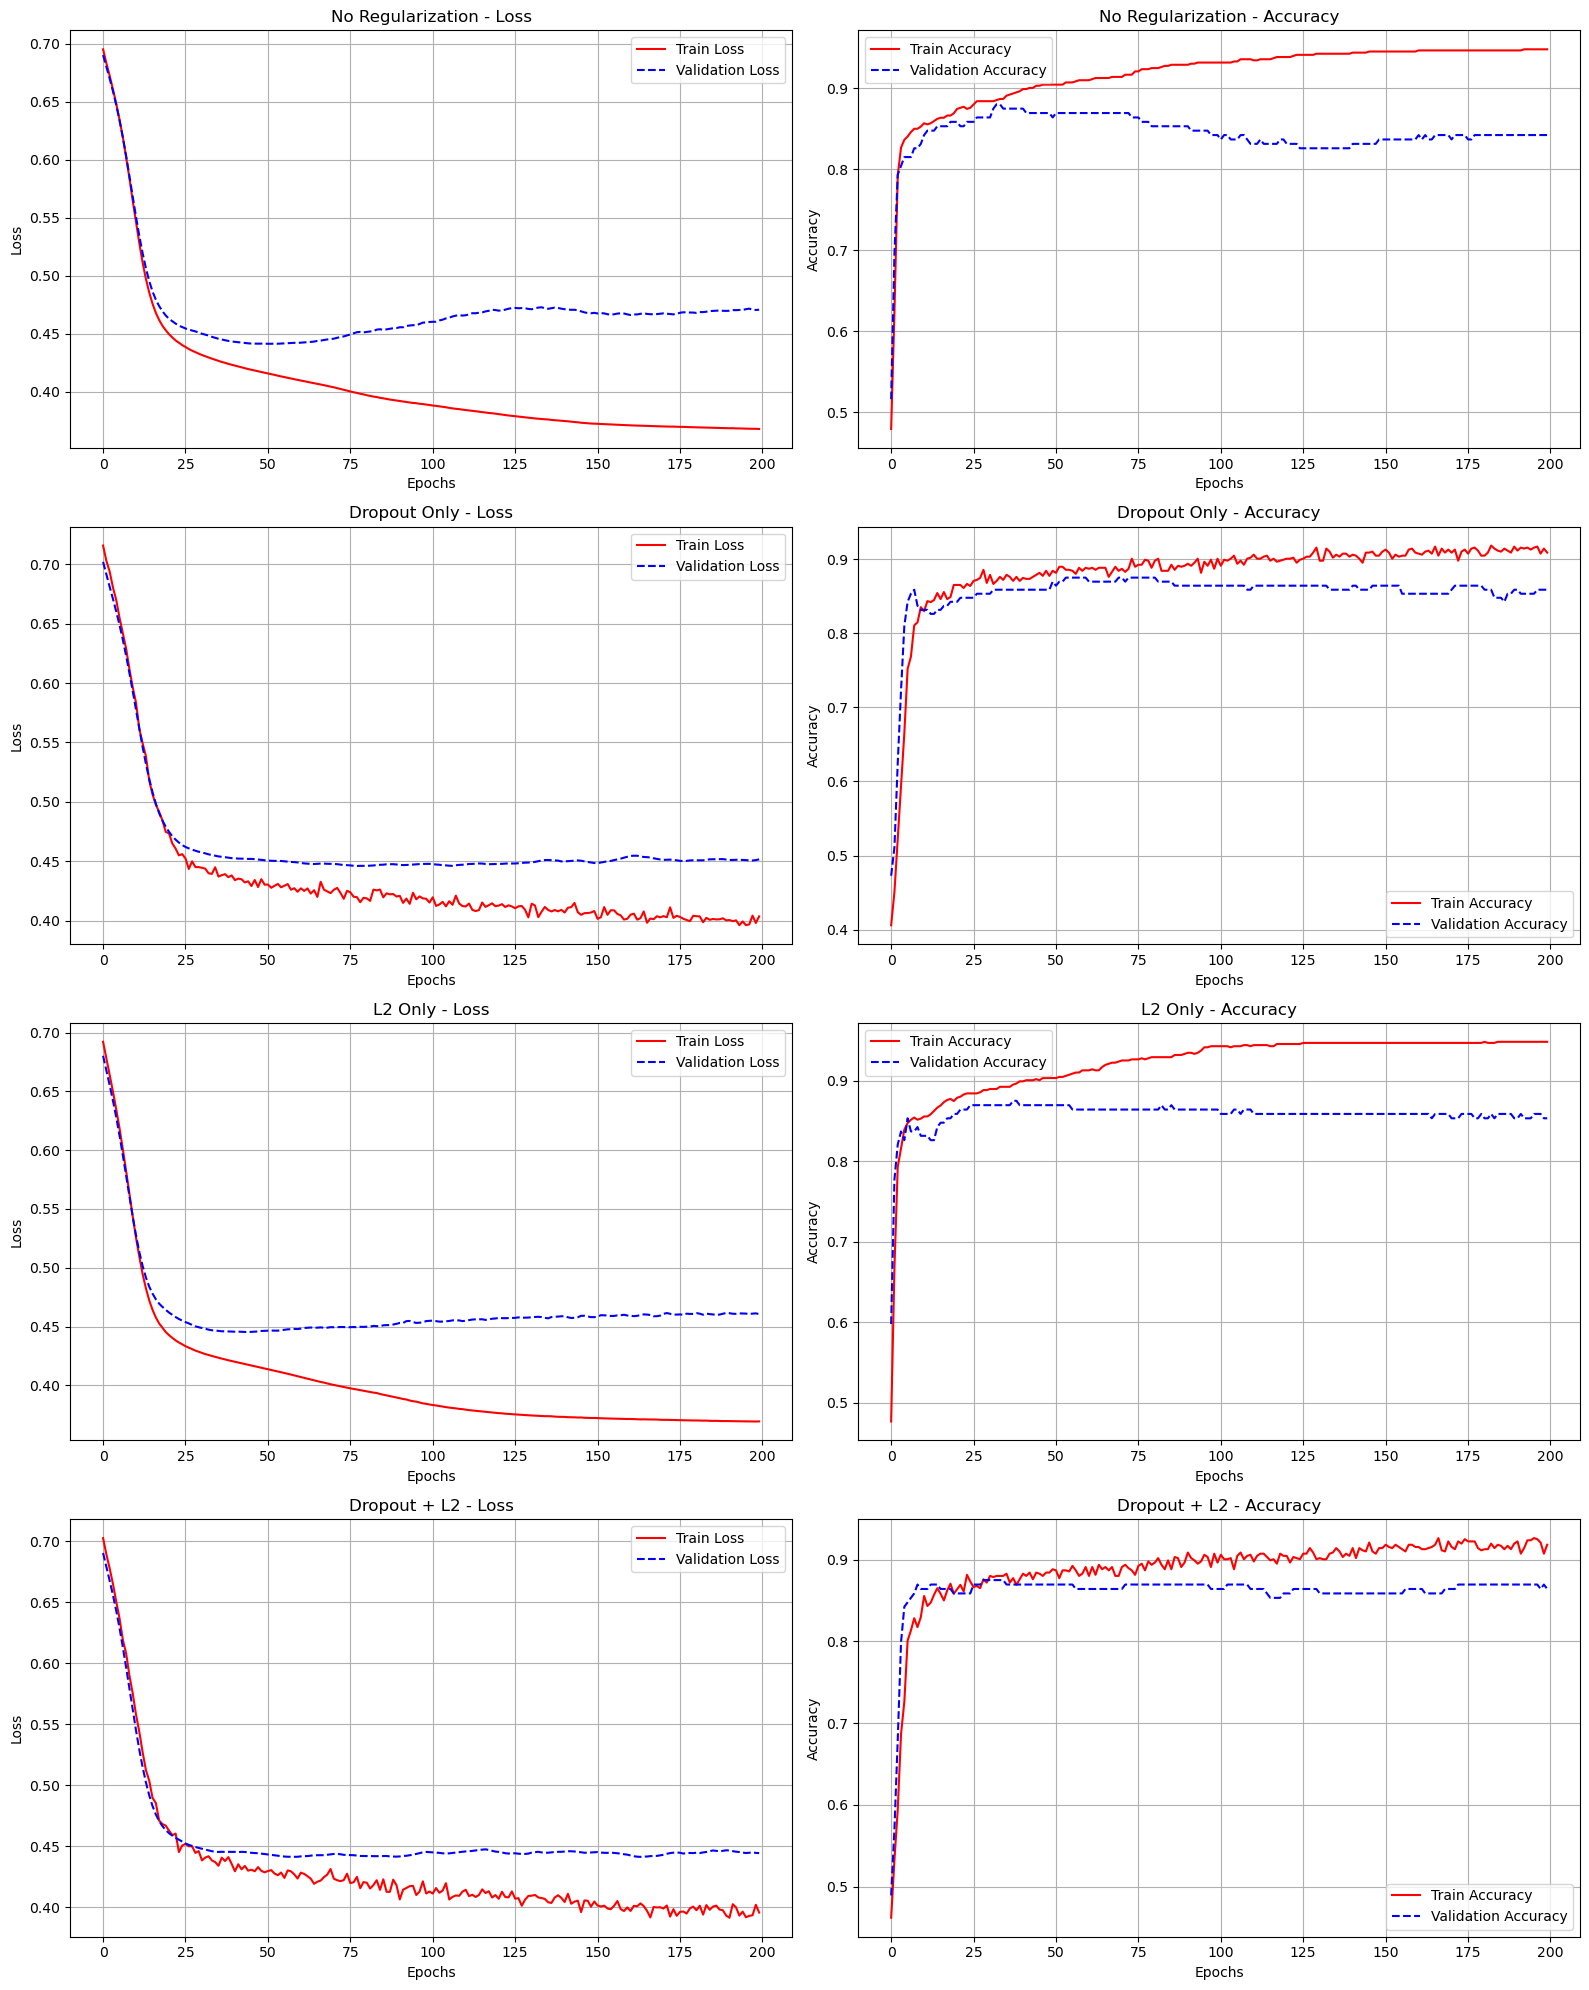

In [29]:
# Experiment configurations
configs = [
    {"label": "No Regularization", "dropout_rate": 0, "alpha": 0},
    {"label": "Dropout Only", "dropout_rate": best_dropout[0], "alpha": 0},
    {"label": "L2 Only", "dropout_rate": 0, "alpha": best_alpha[0]},
    {"label": "Dropout + L2", "dropout_rate":best_dropout[0], "alpha":best_alpha[0]},
]

# Run experiments and collect results
results = {}
num_epochs = 200
for config in configs:
    print(f"Training with config: {config}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(
        config["dropout_rate"],config["alpha"],num_epochs)
    results[config["label"]] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

# Plot results 
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.ravel()

for idx, (label, result) in enumerate(results.items()):
    # Plot train/val losses
    axes[2*idx].plot(result["train_losses"], label="Train Loss", color='red')
    axes[2*idx].plot(result["val_losses"], label="Validation Loss", linestyle="--", color='blue')
    axes[2*idx].set_title(f"{label} - Loss")
    axes[2*idx].set_xlabel("Epochs")
    axes[2*idx].set_ylabel("Loss")
    axes[2*idx].legend()
    axes[2*idx].grid()

    # Plot train/val accuracies
    axes[2*idx+1].plot(result["train_accuracies"], label="Train Accuracy", color='red')
    axes[2*idx+1].plot(result["val_accuracies"], label="Validation Accuracy", linestyle="--", color='blue')
    axes[2*idx+1].set_title(f"{label} - Accuracy")
    axes[2*idx+1].set_xlabel("Epochs")
    axes[2*idx+1].set_ylabel("Accuracy")
    axes[2*idx+1].legend()
    axes[2*idx+1].grid()

plt.tight_layout()
plt.show()

In [30]:
# Print final results numerically with median of differences
print("\nFinal Results (Median of Differences):")
window = 20  # Use the last 20 epochs for evaluation
for label, result in results.items():
    # Compute the difference between training and validation for the last `window` epochs
    loss_differences = np.abs(np.array(result["train_losses"][-window:]) - np.array(result["val_losses"][-window:]))
    acc_differences = np.abs(np.array(result["train_accuracies"][-window:]) - np.array(result["val_accuracies"][-window:]))
    
    # Calculate the median of the differences
    loss_gap_median = np.median(loss_differences)
    acc_gap_median = np.median(acc_differences)
    
    # Print results
    print(f"{label}: Median Loss Gap={loss_gap_median:.4f}, Median Accuracy Gap={acc_gap_median:.4f}")



Final Results (Median of Differences):
No Regularization: Median Loss Gap=0.1012, Median Accuracy Gap=0.1045
Dropout Only: Median Loss Gap=0.0508, Median Accuracy Gap=0.0589
L2 Only: Median Loss Gap=0.0913, Median Accuracy Gap=0.0916
Dropout + L2: Median Loss Gap=0.0482, Median Accuracy Gap=0.0480
